In [7]:
# Install dependencies
!pip install scrapbook recommenders

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [89]:
import os
import math

import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.constants import (
    SEED,
    DEFAULT_PREDICTION_COL as PREDICT_COL
)
from recommenders.datasets.python_splitters import python_random_split
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.utils import tf_utils, gpu_utils, plot
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep

print("Tensorflow Version:", tf.__version__)
print("GPUs:\n", gpu_utils.get_gpu_info())

Tensorflow Version: 2.5.2
GPUs:
 [{'device_name': 'Tesla V100-SXM2-16GB', 'total_memory': 16160.5, 'free_memory': 922.75}]


In [76]:
# Input, output path
INPUT_PATH = '/input'
OUTPUT_PATH = '/output'

# Columns
USER_COL = 'userId'
ITEM_COL = 'movieId'
RATING_COL = 'rating'
ITEM_FEAT_COL = 'genres'

# Recommend top k items
TOP_K = 10

# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]

# Set seed for deterministic result
RANDOM_SEED = SEED

# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32

# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer

# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer

# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [77]:
def load_data(data_dir, filename):
    data_path = os.path.join(data_dir, filename)
    raw_data = pd.read_csv(data_path)
    return raw_data

data = load_data(INPUT_PATH, "ratings.csv")
movies = load_data(INPUT_PATH, "movies.csv")

In [78]:
data.head()
data.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [79]:
# Preprocess dataset
new_data = data.set_index(ITEM_COL).join(movies.set_index(ITEM_COL)).filter([USER_COL, ITEM_COL, RATING_COL, ITEM_FEAT_COL]).reset_index()
genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
new_data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
    new_data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
).tolist()
train, test = python_random_split(new_data, ratio=0.75, seed=RANDOM_SEED)
train.shape[0], test.shape[0]

(75627, 25209)

In [80]:
# Unique items in the dataset
items = new_data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = new_data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 9724 items and 610 users in the dataset


In [81]:
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userId', vocabulary_list=(1, 5, 7, 15, 17, 18, 19, 21, 27, 31,  ...
	 VocabularyListCategoricalColumn(key='movieId', vocabulary_list=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1 ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userId', vocabulary_list=(1, 5, 7, 15, 17,  ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userId', vocabulary_list=(1, ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='movieId', vocabulary_list=(1 ...
	 NumericColumn(key='genres', shape=(20,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


In [82]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)

# Build a model based on the parameters
model_dir = OUTPUT_PATH
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

In [83]:
# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)

In [84]:
# Define training hooks to track performance while training
hooks = []
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=model_dir,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

In [85]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 21)
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.


2022-05-02 14:39:41.132060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:39:41.133161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-02 14:39:41.133300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:39:41.134361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:39:41.135309: I tensorflow/core/common_r

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /output/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


2022-05-02 14:39:45.649597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-02 14:39:46.101199: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-02 14:40:05.390542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:40:05.390993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-02 14:40:05.391088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

INFO:tensorflow:loss = 532.1456, step = 0
INFO:tensorflow:global_step/sec: 15.6449
INFO:tensorflow:loss = 45.746433, step = 5000 (69.686 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...
INFO:tensorflow:Saving checkpoints for 10000 into /output/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...
INFO:tensorflow:global_step/sec: 72.306


/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
2022-05-02 14:46:34.324266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:46:34.324778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-02 14:46:34.324911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUM

INFO:tensorflow:loss = 28.09224, step = 10000 (319.769 sec)
INFO:tensorflow:global_step/sec: 15.6369
INFO:tensorflow:loss = 19.7693, step = 15000 (69.139 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20000...
INFO:tensorflow:Saving checkpoints for 20000 into /output/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20000...
INFO:tensorflow:global_step/sec: 72.2851


/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
2022-05-02 14:53:03.244828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:53:03.245225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-02 14:53:03.245315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUM

INFO:tensorflow:loss = 19.519762, step = 20000 (318.873 sec)
INFO:tensorflow:global_step/sec: 15.6805
INFO:tensorflow:loss = 16.091108, step = 25000 (69.163 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...
INFO:tensorflow:Saving checkpoints for 30000 into /output/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...
INFO:tensorflow:global_step/sec: 72.2896


/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
2022-05-02 14:59:31.004235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:59:31.004655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-02 14:59:31.004746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUM

INFO:tensorflow:loss = 11.002365, step = 30000 (318.227 sec)
INFO:tensorflow:global_step/sec: 15.709
INFO:tensorflow:loss = 20.303299, step = 35000 (69.229 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40000...
INFO:tensorflow:Saving checkpoints for 40000 into /output/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40000...
INFO:tensorflow:global_step/sec: 72.1738


/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
2022-05-02 15:05:58.476011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 15:05:58.476447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-02 15:05:58.476538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUM

INFO:tensorflow:loss = 24.721294, step = 40000 (318.059 sec)
INFO:tensorflow:global_step/sec: 15.7256
INFO:tensorflow:loss = 13.618317, step = 45000 (69.171 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50000...
INFO:tensorflow:Saving checkpoints for 50000 into /output/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50000...
INFO:tensorflow:Loss for final step: 27.700888.


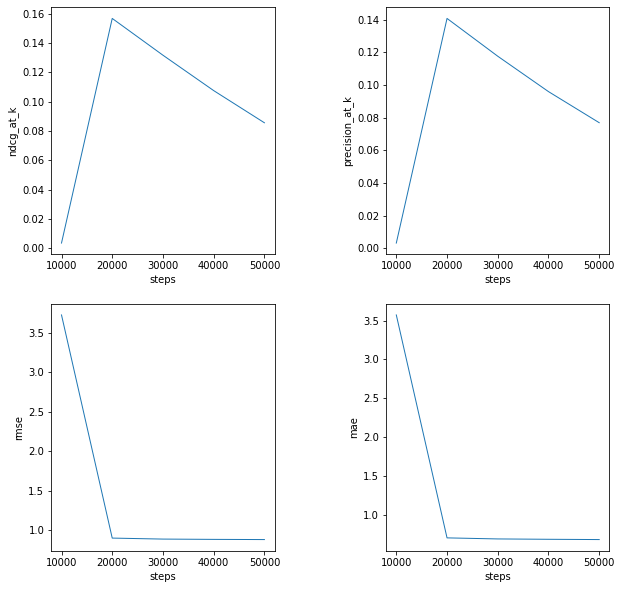

In [90]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )